In [1]:
# Used to pull data from Reddit
import praw
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import statsmodels.formula.api
import matplotlib.pyplot as plt
import time
import re


from gensim.models import Word2Vec
from nltk.corpus import brown
import nltk
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import tensorflow_hub as hub
import multiprocessing
from google.cloud import bigquery

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')

/home/armand_kok/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
W0726 06:57:41.122738 140183800702784 deprecation_wrapper.py:119] From /home/armand_kok/anaconda3/lib/python3.7/site-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [2]:
#post_df.to_csv('reddit_posts_2016_2019.csv')
start_time = time.time()
post_df = pd.read_csv('reddit_posts_2016_2019.csv', parse_dates=['created_dt_month'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.1149632930755615 seconds ---


# Data PreProcessing

In [3]:
title_df = post_df[post_df['is_self'] == True][['title', 'subreddit']]
title_df.loc[title_df['subreddit'] == 'Conservative', 'political_leaning'] = 0
title_df.loc[title_df['subreddit'] == 'republicans', 'political_leaning'] = 0
title_df.loc[title_df['subreddit'] == 'democrats', 'political_leaning'] = 1
title_df.loc[title_df['subreddit'] == 'progressive', 'political_leaning'] = 1

# Neural Network Model

In [4]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
        return text

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "urltoken")
    #text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text


In [185]:
sample_df = title_df.sample(n=5000)[['title', 'political_leaning']]
sample_df['title_clean'] = sample_df['title'].apply(cleanText)
sample_df['word_token'] = sample_df['title_clean'].apply(nltk.word_tokenize)
sample_df['word_count'] = sample_df['word_token'].apply(lambda x: len(x))
sample_df = sample_df[sample_df['word_count']!=0].reset_index(drop=True)
X = np.array(sample_df['title_clean'])
y = np.array(sample_df['political_leaning'])

In [188]:
title_df

,title,subreddit,political_leaning
0,What was the moment or event that made you rea...,Conservative,0.0
1,"Congratulations, we have a ""Guess when we hit ...",Conservative,0.0
283,What are your opinions on the prohibition of m...,Conservative,0.0
284,They keep citing violence against transgender ...,Conservative,0.0
285,Why is r/Politics so biased and attack you for...,Conservative,0.0
286,Do you see what I see? Left-right correlations...,Conservative,0.0
287,How do we define antisemitism?,Conservative,0.0
288,Can we just agree that all politics on reddit ...,Conservative,0.0
289,Having just seen Captain Marvel...,Conservative,0.0
290,Old blog comment but a good one,Conservative,0.0


In [6]:
def ELMoEmbedding(x):
    embed = hub.Module("elmo_model")
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    drop = keras.layers.Dropout(rate=0.4)(embedding)
    dense = Dense(512, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model_elmo = build_model()
model_elmo.summary()

W0726 03:11:13.204061 139901738309440 deprecation.py:506] From /home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0726 03:11:13.268587 139901738309440 deprecation.py:323] From /home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)

Train on 3199 samples, validate on 800 samples
Epoch 1/5
3199/3199 [==============================] - 52s 16ms/sample - loss: 2.1294 - acc: 0.5902 - val_loss: 1.2873 - val_acc: 0.7075
Epoch 2/5
3199/3199 [==============================] - 43s 13ms/sample - loss: 1.3105 - acc: 0.6236 - val_loss: 1.1448 - val_acc: 0.7175
Epoch 3/5
3199/3199 [==============================] - 42s 13ms/sample - loss: 1.2277 - acc: 0.6446 - val_loss: 1.1323 - val_acc: 0.6862
Epoch 4/5
3199/3199 [==============================] - 42s 13ms/sample - loss: 1.1695 - acc: 0.6640 - val_loss: 1.2169 - val_acc: 0.6875
Epoch 5/5
3199/3199 [==============================] - 41s 13ms/sample - loss: 1.0949 - acc: 0.6771 - val_loss: 1.1167 - val_acc: 0.6950


In [9]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model_elmo.evaluate(X_test, y_test)

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f3cd5890620>
Traceback (most recent call last):
  File "/home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


1000/1000 [==============================] - 18s 18ms/sample - loss: 1.3371 - acc: 0.6260


In [10]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = model_elmo.predict(X_test, use_multiprocessing=True, workers=4)

In [11]:
pred_df = pd.DataFrame({'y_prob': y_pred.reshape(y_pred.shape[0]), 'y_actual': y_test})
pred_df.loc[pred_df['y_prob'] >= 0.5, 'y_pred'] = 0.0
pred_df.loc[pred_df['y_prob'] < 0.5, 'y_pred'] = 1.0
print(metrics.classification_report(pred_df['y_actual'], pred_df['y_pred']))

             precision    recall  f1-score   support

        0.0       0.71      0.66      0.68       687
        1.0       0.35      0.40      0.37       313

avg / total       0.59      0.58      0.58      1000



In [16]:
print(metrics.f1_score(pred_df['y_actual'], np.zeros(pred_df.shape[0]), average='macro'))
print(metrics.f1_score(pred_df['y_actual'], pred_df['y_pred'], average='macro'))

0.4072317723770006
0.5255806043028944


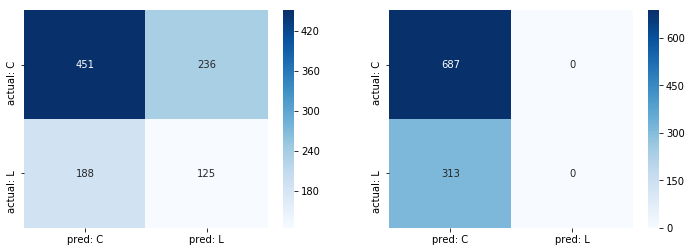

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(metrics.confusion_matrix(pred_df['y_actual'], pred_df['y_pred']), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(pred_df['y_actual'],  np.zeros(pred_df.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

plt.show()

# ELMo Embedding

In [5]:
sample_df = title_df[['title', 'political_leaning']]
sample_df['title_clean'] = sample_df['title'].apply(cleanText)
sample_df['word_token'] = sample_df['title_clean'].apply(nltk.word_tokenize)
sample_df['word_count'] = sample_df['word_token'].apply(lambda x: len(x))
sample_df = sample_df[sample_df['word_count']!=0].reset_index(drop=True)

In [6]:
X = np.array(sample_df['title_clean'])
y = np.array(sample_df['political_leaning'])

X_1 = X[10000:15000].copy()
y_1 = y[10000:15000].copy()

X_2 = X[15000:20000].copy()
y_2 = y[15000:20000].copy()

X_3 = X[20000:25000].copy()
y_3 = y[20000:25000].copy()

X_4 = X[25000:].copy()
y_4 = y[25000:].copy()

In [ ]:
#X - batch 0 - 249 
#X_1 - batch

In [7]:
batch_size = 40
X_list = [X_1[i:i+batch_size] for i in range(0, X_1.shape[0], batch_size)]

X_vecs = []
elmo_model = hub.Module('elmo_model', trainable=False)
for x in enumerate(X_list):
    embeddings = elmo_model(x[1], signature="default", as_dict=True)['default']
    start_time = time.time()
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        elmo_embedding = sess.run(embeddings)
    print('batch', x[0], 'complete - ', '%s seconds' % (time.time() - start_time))
    X_vecs += list(elmo_embedding)

batch 0 complete -  4.328624963760376 seconds
batch 1 complete -  1.2042064666748047 seconds
batch 2 complete -  1.2423393726348877 seconds
batch 3 complete -  1.348501205444336 seconds
batch 4 complete -  1.4216303825378418 seconds
batch 5 complete -  1.470273494720459 seconds
batch 6 complete -  1.647254467010498 seconds
batch 7 complete -  1.5298404693603516 seconds
batch 8 complete -  1.6229321956634521 seconds
batch 9 complete -  1.7937343120574951 seconds
batch 10 complete -  1.9614379405975342 seconds
batch 11 complete -  1.8693878650665283 seconds
batch 12 complete -  2.1148734092712402 seconds
batch 13 complete -  2.082824945449829 seconds
batch 14 complete -  2.0792899131774902 seconds
batch 15 complete -  2.2370691299438477 seconds
batch 16 complete -  2.508500814437866 seconds
batch 17 complete -  2.689424753189087 seconds
batch 18 complete -  2.4701263904571533 seconds
batch 19 complete -  2.449129343032837 seconds
batch 20 complete -  2.939864158630371 seconds
batch 21 co

In [29]:
len(X_list)

680

In [22]:
json_df = pd.DataFrame({'title_clean':X_1,
                        'elmo_embedding':X_vecs,
                        'political_leaning': y_1})

In [23]:
json_df.to_json('15k20k_elmo.json', orient='split')

In [ ]:
#10000_elmo.json'
#15k20k_elmo.json

In [137]:
json_df = pd.read_json('5000_elmo.json', orient='split')

In [139]:
json_df.head()

,title_clean,elmo_embedding,political_leaning
0,advice for a young gop voter,"[-0.1192468777, -0.0149583621, 0.1186742261, -...",0
1,questions for conservatives,"[-0.5192691684, -0.37184229490000004, 0.579375...",0
2,we need to talk about mod uchabanais,"[-0.40365633370000004, -0.7558580041, 0.183598...",0
3,the kavanaugh proceedings are illegal and russ...,"[0.23557116090000002, -0.26370611790000004, 0....",1
4,finally the good side of reddit,"[-0.0964441523, -0.19368620220000002, 0.340434...",0


# Random Forest

In [183]:
sample_df['title_clean']

0        what was the moment or event that made you rea...
1        congratulations we have a guess when we hit 20...
2        what are your opinions on the prohibition of m...
3        they keep citing violence against transgender ...
4        why is rpolitics so biased and attack you for ...
5        do you see what i see left-right correlations ...
6                            how do we define antisemitism
7        can we just agree that all politics on reddit ...
8                          having just seen captain marvel
9                          old blog comment but a good one
10                   how to deal with brainwashed students
11                           captain marxist and hollywood
12                                     climate change poll
13       latest brooklyn nine-nine episode about sexual...
14                it is a shi--y job but it pays the bills
15           i just had an epiphany about diversity quotas
16       instead of building a wall can we not just giv.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_vecs, y, test_size = 0.2)

model = RandomForestClassifier(n_estimators=1000,
                               n_jobs=10,
                               class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [172]:
print(metrics.classification_report(y_test, np.zeros(y_test.shape[0])))
print(metrics.classification_report(y_test, model.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.67      1.00      0.80       671
        1.0       0.00      0.00      0.00       329

avg / total       0.45      0.67      0.54      1000

             precision    recall  f1-score   support

        0.0       0.70      0.97      0.82       671
        1.0       0.75      0.16      0.26       329

avg / total       0.72      0.71      0.63      1000



In [173]:
metrics.accuracy_score(y_test, model.predict(X_test))

0.706

In [174]:
1-(y_test.sum()/y_test.shape[0])

0.671

In [165]:
model.score(X_test, y_test)

0.699

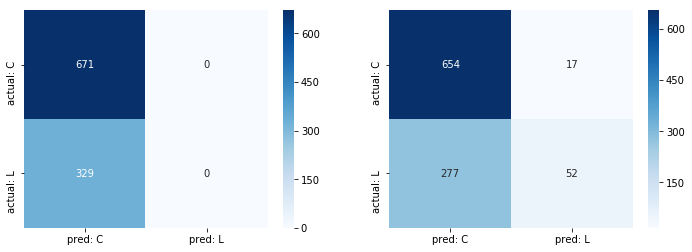

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(metrics.confusion_matrix(y_test, np.zeros(y_test.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(y_test, model.predict(X_test)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

plt.show()